In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Model selection using Recursive elimination

In [18]:
housing = pd.read_csv('data/Housing.csv')

### Data preparation
* transforming yes and no into Binary
* also do some innovation in furnished data

In [19]:
# map is an extension pf pandas
housing['mainroad'] = housing['mainroad'].map({'yes':1,'no':0})
housing['guestroom'] = housing['guestroom'].map({'yes':1,'no':0})
housing['basement'] = housing['basement'].map({'yes':1,'no':0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes':1,'no':0})
housing['airconditioning'] = housing['airconditioning'].map({'yes':1,'no':0})
housing['prefarea'] = housing['prefarea'].map({'yes':1,'no':0})

In [20]:
# data refacor
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)
housing = pd.concat([housing,status],axis=1)
housing.drop(['furnishingstatus'],axis=1,inplace=True)

In [21]:
housing['areaPerBedroom'] = housing['area']/housing['bedrooms']
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

In [29]:
def normalize(x):
    minVal = min(x)
    return (x - minVal) / (max(x) - minVal)

In [30]:
housing = housing.apply(normalize)

In [31]:
all_list = np.array(housing.columns)
x_list = all_list[all_list!='price'] # filtering

X = housing[x_list]
y = housing['price']

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.7,random_state=100)


## RFE

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [39]:
# 9 indicates how many columns we want best of them
lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=9)
rfe = rfe.fit(X=X_train,y=y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True False False  True  True False  True False
 False  True  True]
[1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


In [58]:
col = X_train.columns[rfe.support_]
print(col)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Building Model using sklearn

In [43]:
X_train_rfe = X_train[col]

In [45]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [46]:
lm = sm.OLS(y_train,X_train_rfe).fit()

In [47]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           1.89e-81
Time:                        16:11:00   Log-Likelihood:                 369.50
No. Observations:                 381   AIC:                            -719.0
Df Residuals:                     371   BIC:                            -679.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4402      0.132     

In [48]:
def vif_cal(input_data,dependent_col):
    vif_df = pd.DataFrame(columns=['Var','Vif'])
    x_vars = input_data.drop([dependent_col],axis=1)
    x_var_name = x_vars.columns
    for i in range(0,x_var_name.shape[0]):
        y = x_vars[x_var_name[i]]
        x = x_vars[x_var_name.drop(x_var_name[i])]
        rsq = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-rsq),2)
        vif_df.loc[i] = [x_var_name[i],vif]
    return vif_df.sort_values(by='Vif',axis=0,ascending=False,inplace=False)

In [57]:
# vif_cal(input_data=housing,dependent_col='price')

,Var,Vif
13,areaPerBedroom,251.16
0,area,232.60
2,bathrooms,161.60
1,bedrooms,151.10
14,bbratio,22.30
3,stories,10.99
4,mainroad,8.16
11,semi-furnished,2.71
12,unfurnished,2.50
6,basement,2.04


## Model Predictions

In [59]:
X_test_rfe = X_test[col]

X_test_rfe = sm.add_constant(X_test_rfe)

y_pred = lm.predict(X_test_rfe)

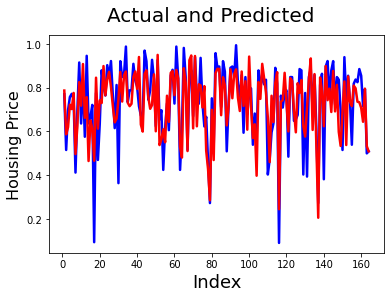

In [60]:
# actual vs predicted
c = [i for i in range(1,165,1)] # 544 total .3 is 165
fig = plt.figure()
plt.plot(c,y_test,color='blue',linewidth=2.5,linestyle ='-')
plt.plot(c,y_pred,color='red',linewidth=2.5,linestyle='-')
fig.suptitle('Actual and Predicted',fontsize=20)
plt.xlabel('Index',fontsize=18)
plt.ylabel('Housing Price',fontsize=16)
plt.show()

## Error Margin

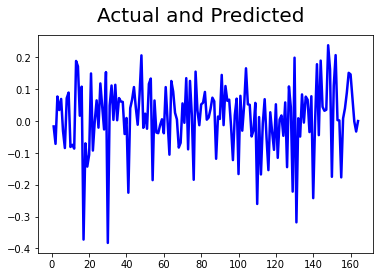

In [62]:
# actual vs predicted
c = [i for i in range(1,165,1)] # 544 total .3 is 165
fig = plt.figure()
plt.plot(c,y_test - y_pred,color='blue',linewidth=2.5,linestyle ='-')
fig.suptitle('Actual and Predicted',fontsize=20)
plt.show()

